In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [4]:
context = ingestor.Context("runs/passive6.1.run")

In [5]:
solver = fitter.Fitter(context)

In [6]:
for rhoi in np.logspace(-6, 5, num=45):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [7]:
solver.write("out/dense33solutions.out")

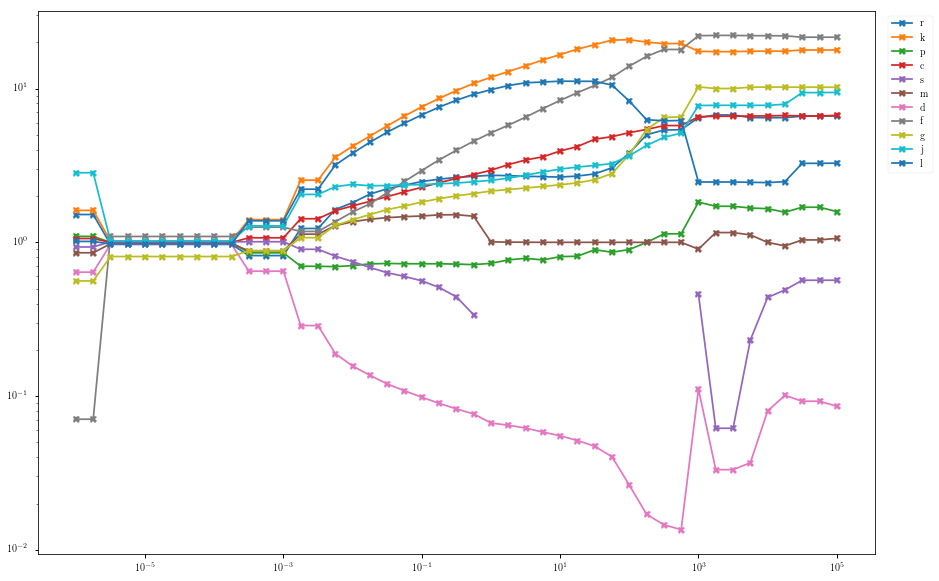

In [8]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

Text(0.5, 1.0, 'Outer Objective Function Values by Algo Parameter')

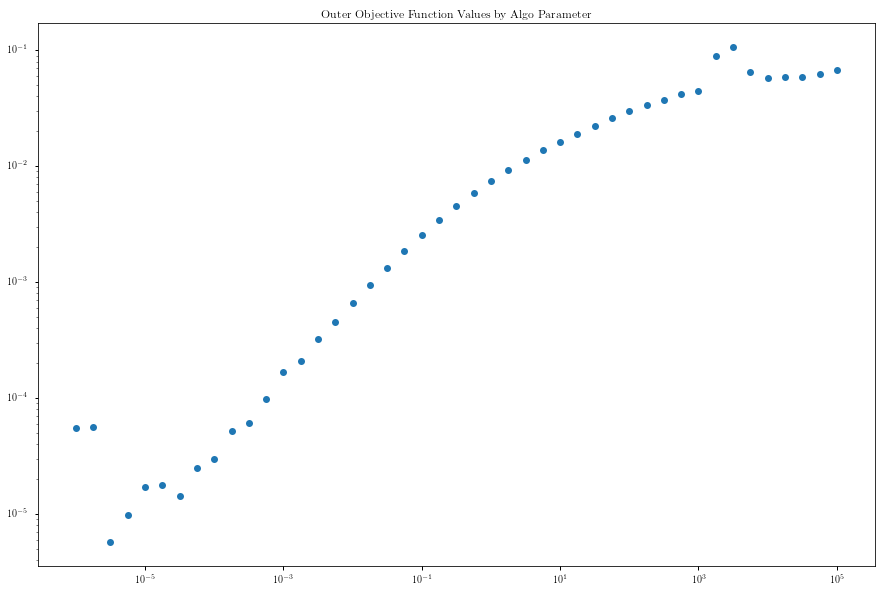

In [9]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o')
plt.title("Outer Objective Function Values by Algo Parameter")

Text(0, 0.5, 'Number')

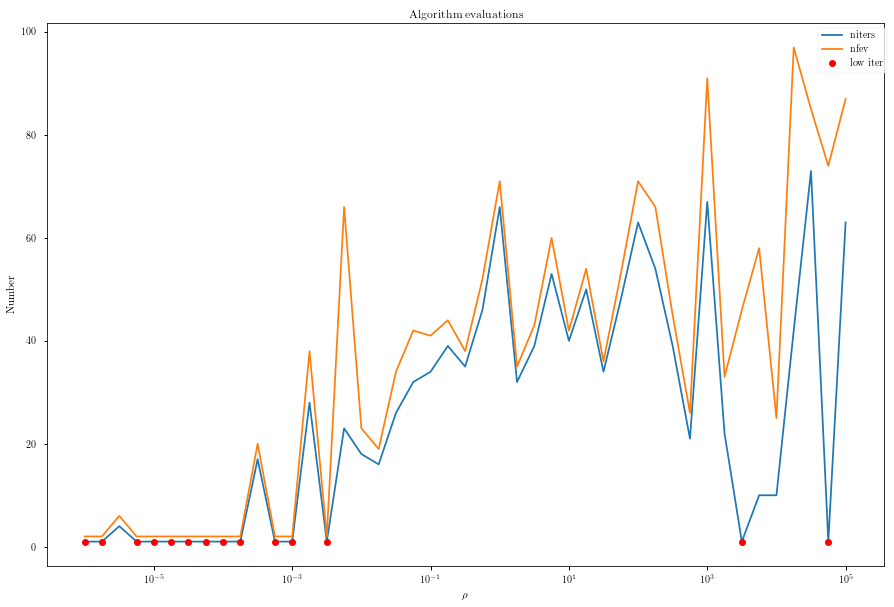

In [10]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 2])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [11]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [solver.models[0].ts, *solver.models[0].cs], solver.models[0].xs)
model = solver.models[0]

[ 2.67356451 15.36023958  0.76814465  3.59924927  0.          1.00031113
  0.05833629  7.4115876   2.30869955  2.86908277 11.02863637]
[[ 0.00083712  0.06730685 -0.39174786]]
[[ 0.00674065  0.18430599 -2.21274426]]


Text(0.5, 0, 'time, t')

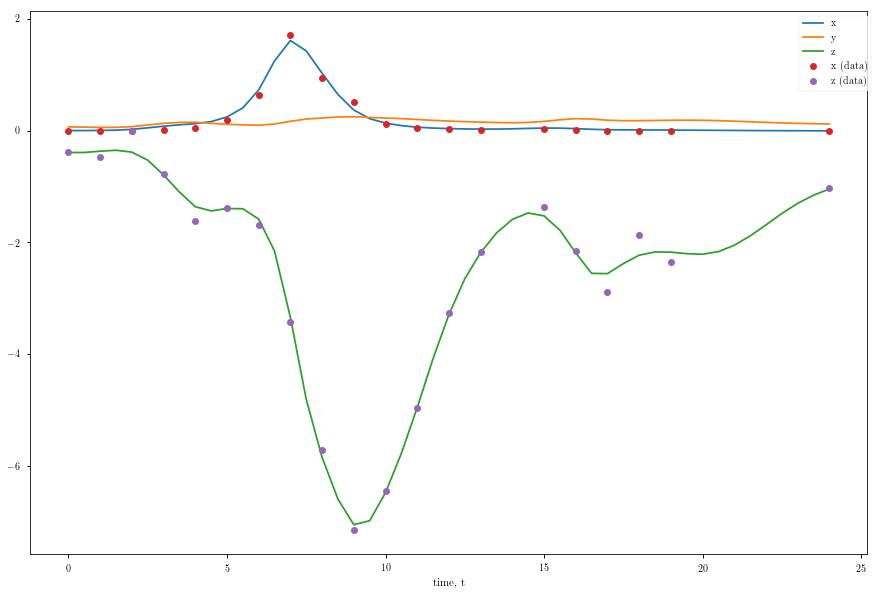

In [12]:
target_rho = 5.623413251903491
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x
print(solver.solutions[str(target_rho)][0].x)
xs_end = np.array([np.array(i) for i in getx(solver.models[0].observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
print(xs_end[:,0].T)
print(xs_end[:,-9].T)
plt.plot(solver.models[0].observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context.datasets[0]['t'], context.datasets[0]['x'], 'o',
         context.datasets[0]['t'], context.datasets[0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

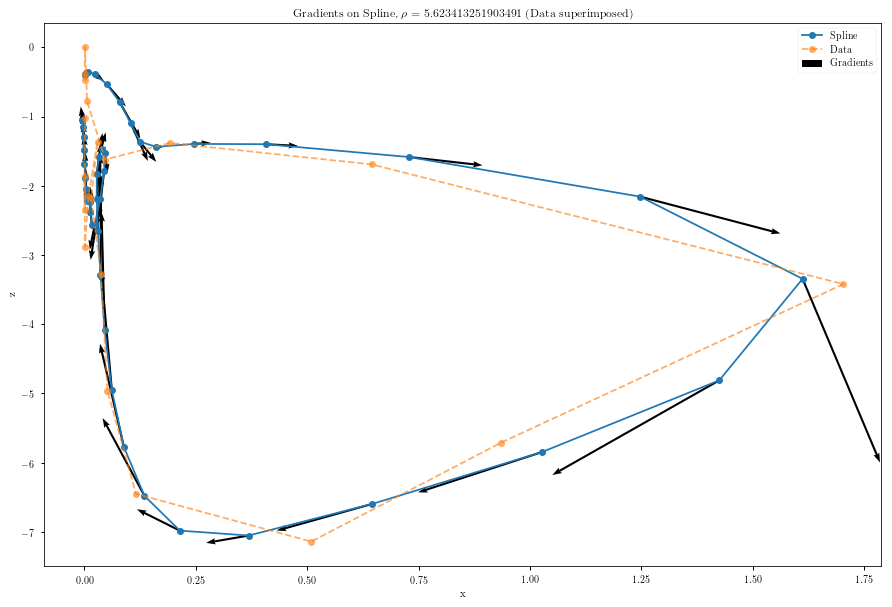

In [13]:
spline_dfield = np.array([context.model(t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context.datasets[0]['x'], context.datasets[0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

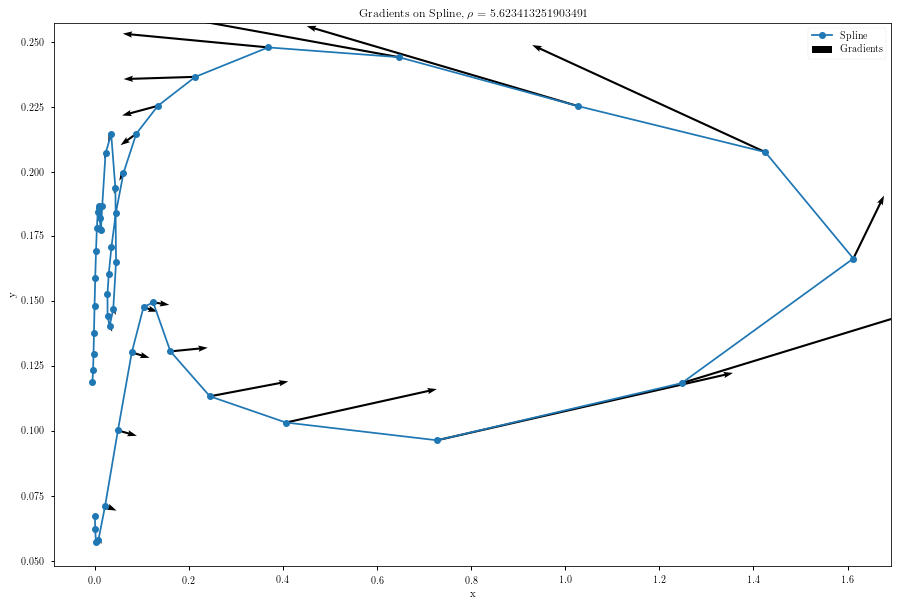

In [14]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

In [15]:
tf_fn = lambda r, v: solver.inner_objectives[0].inner_criterion_fn(solver.models[0].observation_times,
                                                                 *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                                 *v,
                                                                 solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                                 len(context.datasets[0]['t']),
                                                                 *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                                 r)
tf_values = np.array([[r, tf_fn(r, v)] for r, v in zip(rhos, vals)])

In [16]:
oo_fn = lambda r, v: solver.inner_objectives[0]._obj_fn1(solver.models[0].observation_times,
                                                         *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                         *v,
                                                         solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                         len(context.datasets[0]['t']),
                                                         *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                         r)
datafit_values = np.array([[r, oo_fn(r, v)] for r, v in zip(rhos, vals)])

In [17]:
dfield_fn = lambda r, v: solver.inner_objectives[0]._obj_fn2(solver.models[0].observation_times,
                                                             *fitter.argsplit(solver.problems[0].cache.results[tokey(r, v)].x, 3),
                                                             *v,
                                                             solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
                                                             len(context.datasets[0]['t']),
                                                             *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
                                                             r)

dfield_direct = np.array([[r, dfield_fn(r, v)] for r, v in zip(rhos, vals)])

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

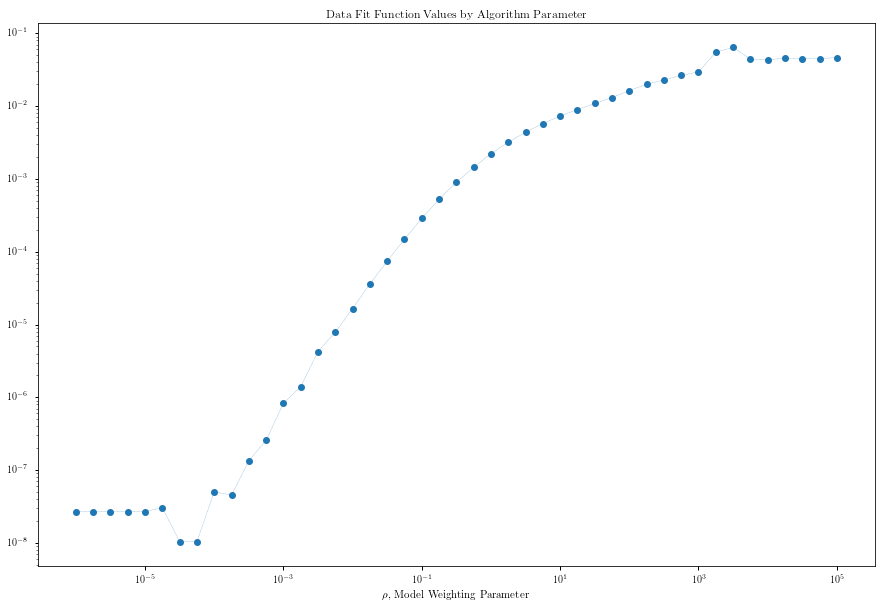

In [18]:
plt.loglog(*datafit_values.T, 'o--', linewidth=0.25)
plt.title("Data Fit Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

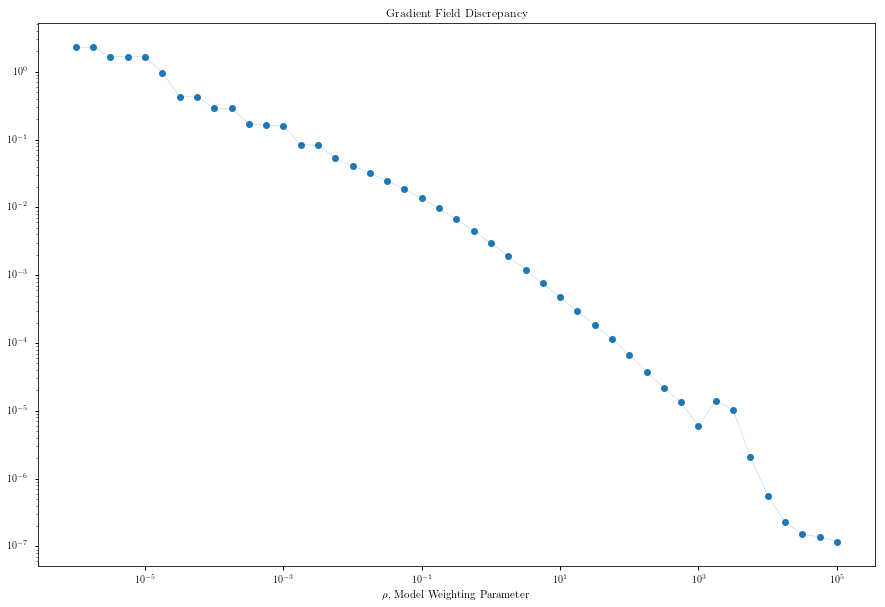

In [19]:
plt.loglog(*dfield_direct.T, 'o--', linewidth=0.25)
plt.title("Gradient Field Discrepancy")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

Text(0, 0.5, 'Diff Field')

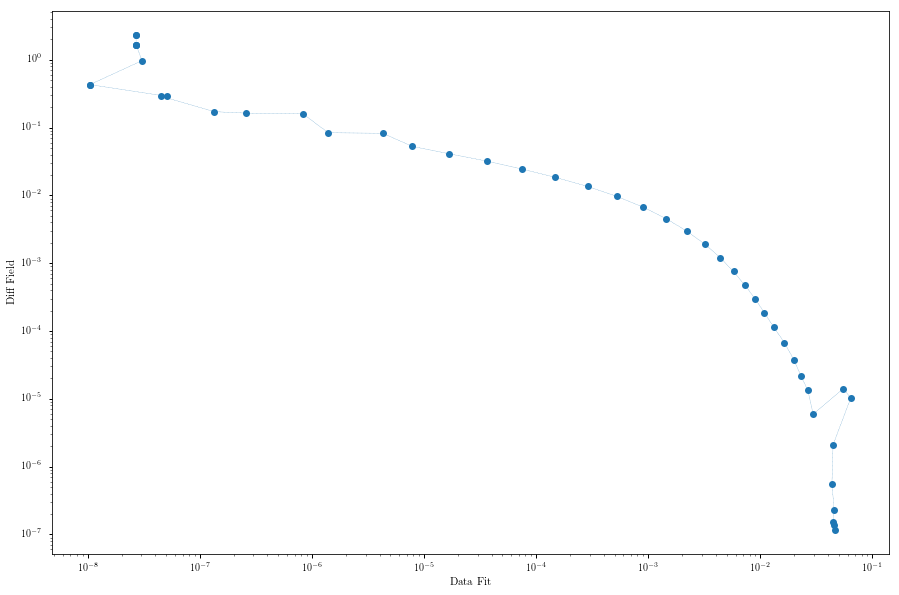

In [20]:
plt.loglog(datafit_values[:,1], dfield_direct[:,1], '--o', linewidth=0.25)
plt.xlabel("Data Fit")
plt.ylabel("Diff Field")


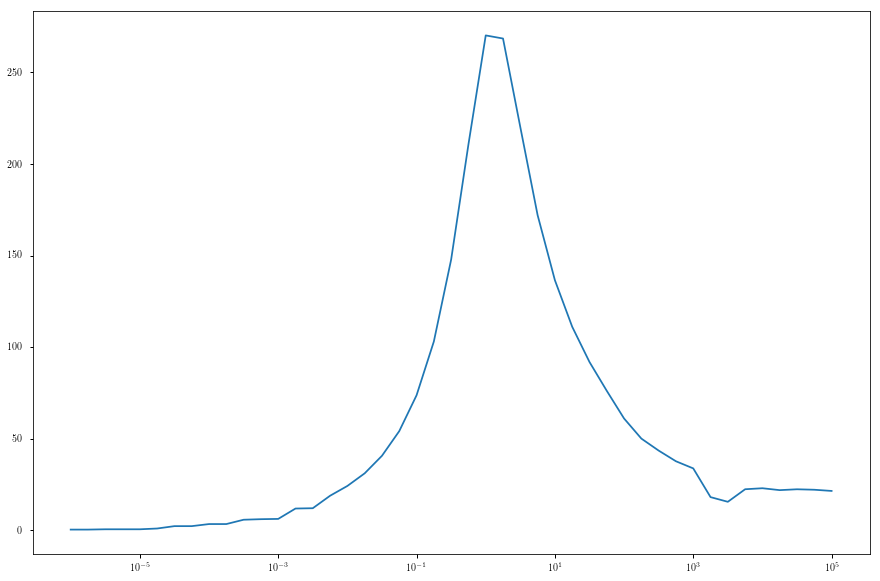

In [21]:
plt.semilogx(rhos, [1/np.sqrt(x**2+y**2) for x,y in zip(datafit_values[:,1], dfield_direct[:,1])])

Text(0.5, 1.0, 'Gradient Field')

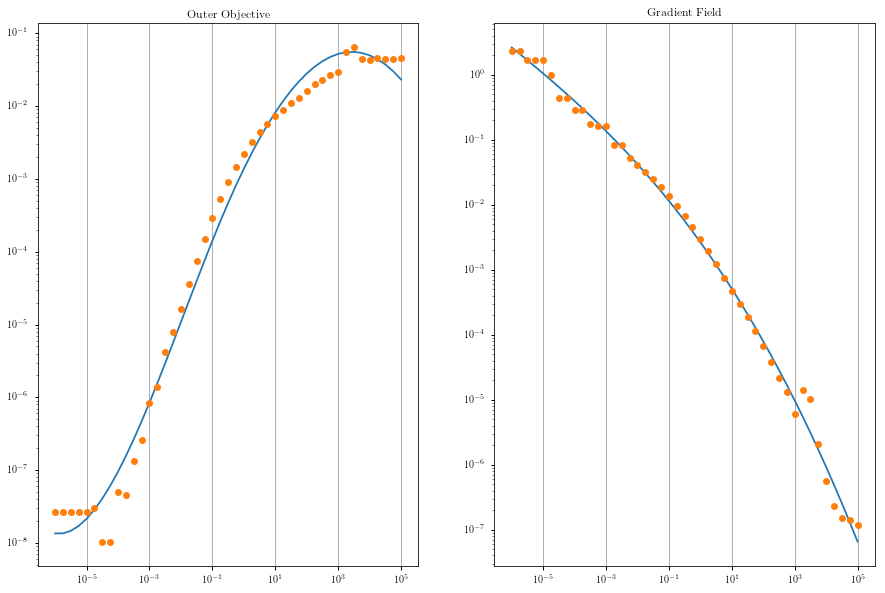

In [22]:
from scipy import interpolate
smooth_outer = interpolate.UnivariateSpline(np.log10(rhos), np.log10(datafit_values[:,1]), s=3)
souter =  np.array([10**x for x in smooth_outer(np.log10(rhos))])
smooth_dfield = interpolate.UnivariateSpline(np.log10(rhos), np.log10(dfield_direct[:,1]), s=4)
sfield =  np.array([10**x for x in smooth_dfield(np.log10(rhos))])

fig, axs = plt.subplots(ncols=2)
axs[0].loglog(rhos, souter, rhos, datafit_values[:,1], 'o')
axs[0].xaxis.grid(True)
axs[0].set_title("Outer Objective")
axs[1].loglog(rhos, sfield, rhos, dfield_direct[:,1], 'o')
axs[1].xaxis.grid(True)
axs[1].set_title("Gradient Field")

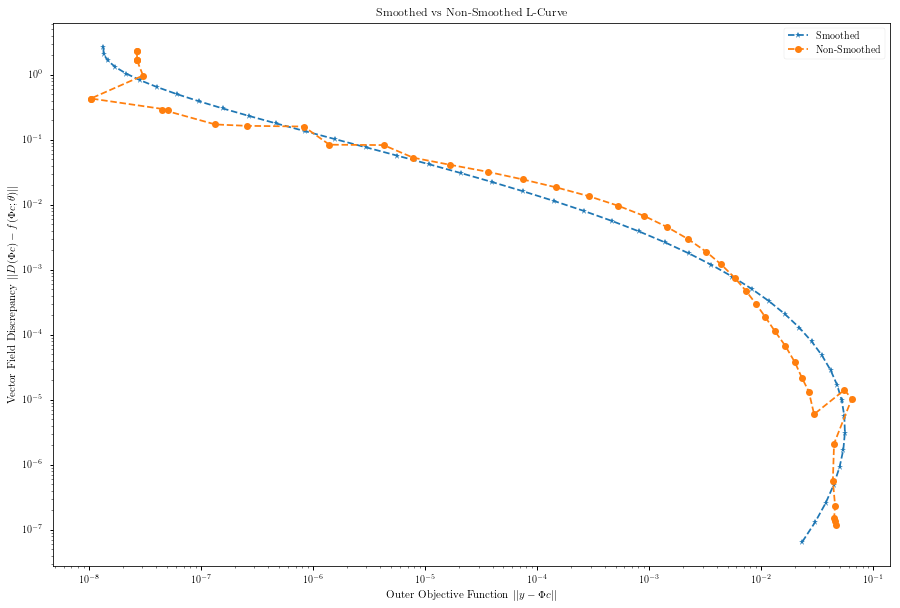

In [23]:
plt.loglog(souter, sfield, '*--', datafit_values[:,1], dfield_direct[:,1], 'o--')
plt.title("Smoothed vs Non-Smoothed L-Curve")
plt.xlabel(r"Outer Objective Function $||y-{\Phi}c||$")
plt.ylabel(r"Vector Field Discrepancy $||D({\Phi}c) - f({\Phi}c; \theta)||$")
plt.legend(["Smoothed", "Non-Smoothed"])

Text(0, 0.5, '$\\kappa$')

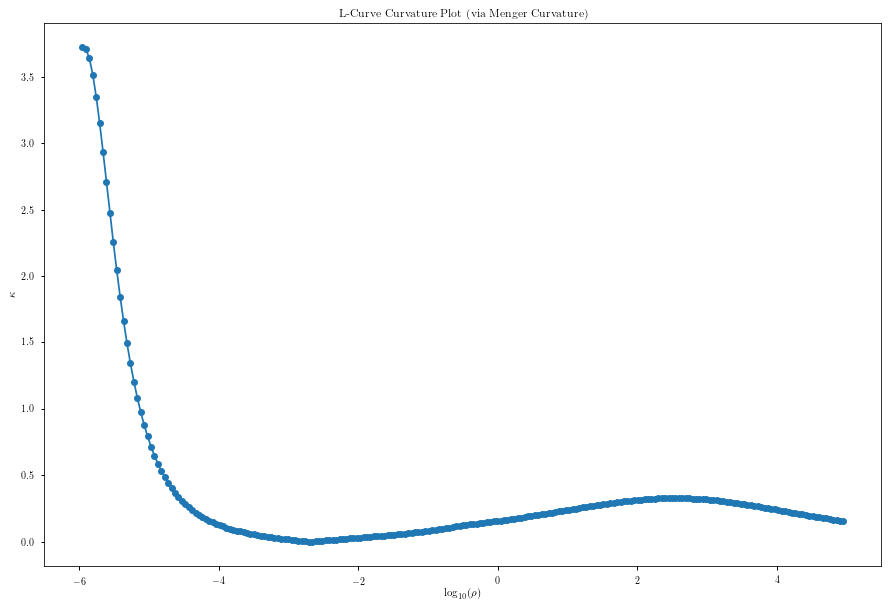

In [24]:
rhos_log_finer = np.linspace(np.log10(rhos[0]), np.log10(rhos[-1]), len(rhos)*5)

curvs = []

sx = smooth_outer(rhos_log_finer)
sy = smooth_dfield(rhos_log_finer)

for idx in range(1, len(rhos_log_finer)-1):
    xs = sx[idx-1:idx+2]
    ys = sy[idx-1:idx+2]
    ps = np.vstack([xs,ys]).T
    curvs.append(2*np.abs(np.cross(ps[1] - ps[0], ps[2]-ps[1]))/(
            np.linalg.norm(ps[0]-ps[1])*np.linalg.norm(ps[1]-ps[2])*np.linalg.norm(ps[2]-ps[0])))

plt.plot(rhos_log_finer[1:-1], np.array(curvs), 'o-')
plt.title("L-Curve Curvature Plot (via Menger Curvature)")
plt.xlabel(r"$\log_{10}(\rho)$")
plt.ylabel(r"$\kappa$")

In [25]:
print(10 ** rhos_log_finer[np.argmax(curvs) + 1])

1.119714089070372e-06


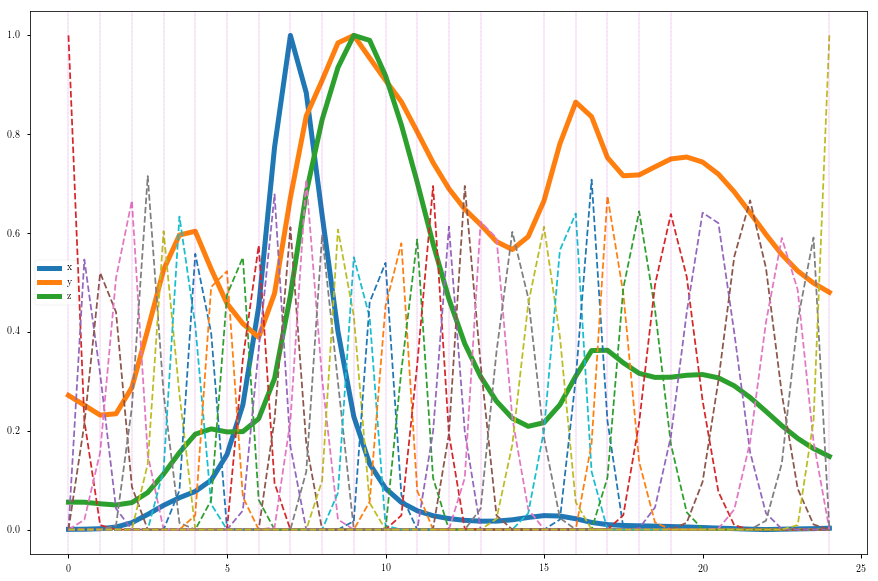

In [26]:
bfn = modeller.ca.Function('basis_fns', [solver.models[0].ts], [solver.models[0].basis])
plt.plot(solver.models[0].observation_times, np.abs(np.hstack([xs_end[0]/max(abs(xs_end[0])), 
                                             xs_end[1]/max(abs(xs_end[1])), 
                                             xs_end[2]/max(abs(xs_end[2]))])),
         linewidth=5)
plt.plot(solver.models[0].observation_times, bfn(solver.models[0].observation_times), '--')
plt.legend('xyz')
[plt.axvline(x=i, color='m', linewidth=0.25, linestyle='--') for i in context.datasets[0]['t']]
print("")

In [28]:
# for each parameter, evaluate local curvature
ps_end = solver.solutions[str(target_rho)][0].x
fisher = []
for p in solver.models[0].ps:
    H,g = fitter.ca.hessian(solver.inner_objectives[0].inner_criterion, p)
    hfn = fitter.ca.Function('hfn', solver.inner_objectives[0].input_list, [H])
    fisher.append(float(hfn(solver.models[0].observation_times,
              *fitter.argsplit(solver.problems[0].cache.results[tokey(target_rho, ps_end)].x, 3),
              *ps_end,
              solver.inner_objectives[0].generate_collocation_matrix(context.datasets[0], solver.models[0]),
              len(context.datasets[0]['t']),
              *solver.inner_objectives[0].pad_observations(context.datasets[0]['y']),
              target_rho)))
print(fisher)

[1.9968669200351834, 0.06450082398290065, 0.009365963880478142, 0.001451704338154394, 0.00042997496882951267, 0.0, 0.3042463797720016, 4.608711501883903, 103.36657225714873, 1.9968669200351834, 0.3042463797720016]


/home/dwu402/.virtualenvs/scider/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


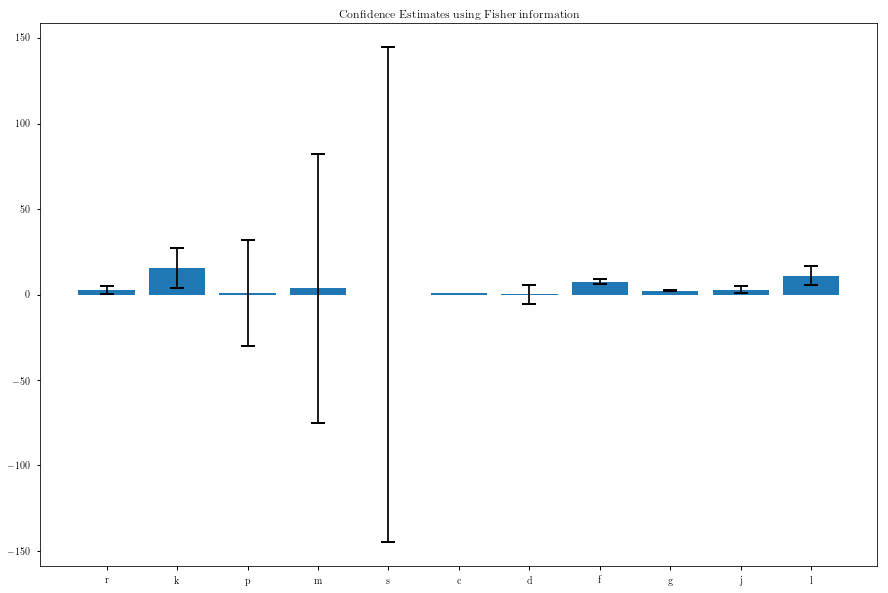

In [29]:
px = range(len(ps_end))
plt.bar(px, ps_end)
plt.errorbar(px, ps_end, yerr=3*np.sqrt(1/np.array(fisher)), 
             capsize=7, markeredgewidth=2, linestyle='None', ecolor='k', color='k')
plt.xticks(px, 'rkpmscdfgjl')
plt.title("Confidence Estimates using Fisher information")
print('')

In [27]:
rhos

[1e-06,
 1.778279410038923e-06,
 3.162277660168379e-06,
 5.623413251903491e-06,
 1e-05,
 1.778279410038923e-05,
 3.1622776601683795e-05,
 5.623413251903491e-05,
 0.0001,
 0.00017782794100389227,
 0.00031622776601683794,
 0.0005623413251903491,
 0.001,
 0.0017782794100389228,
 0.0031622776601683794,
 0.005623413251903491,
 0.01,
 0.01778279410038923,
 0.03162277660168379,
 0.05623413251903491,
 0.1,
 0.1778279410038923,
 0.31622776601683794,
 0.5623413251903491,
 1.0,
 1.7782794100389228,
 3.1622776601683795,
 5.623413251903491,
 10.0,
 17.78279410038923,
 31.622776601683793,
 56.23413251903491,
 100.0,
 177.82794100389228,
 316.22776601683796,
 562.341325190349,
 1000.0,
 1778.2794100389228,
 3162.2776601683795,
 5623.413251903491,
 10000.0,
 17782.794100389227,
 31622.776601683792,
 56234.13251903491,
 100000.0]